# PROJET ANALYSE DE DONNEES
## Etude des stations de location de vélos dans Paris

In [5]:
library(ggplot2)
library(reshape2)
library(gridExtra)
library(tidyverse)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet)
library(ggfortify)
library(pROC)
library(ROCR)
library(RColorBrewer)
library(viridis)
library(leaflet)
library(mapview)

ERROR: Error in library(GGally): there is no package called 'GGally'


## 1. Présentation des données

In [3]:
# on charge les données
load('data/velib.RData')
summary(velib)

         Length Class      Mode     
data      181   data.frame list     
position    2   data.frame list     
dates     181   -none-     character
bonus    1189   -none-     numeric  
names    1189   -none-     character

L'objectif de ce projet est d'analyser un dataset venant du système Velib de Paris. Les données sont le chargement des stations sur une semaine. 
Le jeu de données contient : \
1 - data : le profil de chargement des 1189 stations à 181 heures différentes. Un chargement de 1 veut dire que la station est pleine de vélos alors qu'un chargement de 0 indique une station vide. \
2 - position : la latitude et la longitude des 1189 stations \
3 - dates : la date de téléchargement \
4 - bonus : si bonus=1, la station est en altitude et si bonus=0 elle ne l'est pas \
5 - names : le nom des stations 

In [4]:
# on prépare les données
loading = as.matrix(velib$data)
colnames(loading) = 1:ncol(loading)
rownames(loading) = velib$names

stations = 1:nrow(loading)
coord = velib$position[stations,]
coord$bonus = velib$bonus[stations]

# on prend exactement 7 jours de données (on enlève les 13 premières heures)
dates = 14:181
loading = loading[stations, dates]
colnames(loading) = 1:length(dates)
head(loading)
head(coord)

,1,2,3,4,5,6,7,8,9,10,...,159,160,161,162,163,164,165,166,167,168
EURYALE DEHAYNIN,0.03846154,0.03846154,0.07692308,0.03846154,0.03846154,0.03846154,0.03846154,0.03846154,0.10714286,0.00000000,...,0.29629630,0.11111111,0.1111111,0.14814815,0.30769231,0.07692308,0.11538462,0.07692308,0.1538462,0.1538462
LEMERCIER,0.47826087,0.47826087,0.47826087,0.43478261,0.43478261,0.43478261,0.43478261,0.43478261,0.26086957,0.04347826,...,0.04347826,0.00000000,0.2173913,0.13043478,0.04545455,0.17391304,0.17391304,0.17391304,0.2608696,0.3913043
MEZIERES RENNES,0.21818182,0.14545455,0.12727273,0.10909091,0.10909091,0.10909091,0.09090909,0.09090909,0.05454545,0.10909091,...,0.25925926,0.25925926,0.2037037,0.12962963,0.14814815,0.29629630,0.31481481,0.37037037,0.3703704,0.4074074
FARMAN,0.95238095,0.95238095,0.95238095,0.95238095,0.95238095,0.95238095,0.95238095,1.00000000,1.00000000,1.00000000,...,1.00000000,1.00000000,0.9047619,0.85714286,0.85714286,0.85714286,0.76190476,0.76190476,0.7619048,0.7619048
QUAI DE LA RAPEE,0.92753623,0.81159420,0.73913043,0.72463768,0.72463768,0.72463768,0.72463768,0.72463768,0.75362319,0.97101449,...,0.22727273,0.45454545,0.5909091,0.83333333,1.00000000,0.81818182,0.63636364,0.71212121,0.6212121,0.5757576
CHOISY POINT D'IVRY,0.16666667,0.16666667,0.16666667,0.16666667,0.16666667,0.16666667,0.16666667,0.16666667,0.08333333,0.00000000,...,0.34782609,0.08695652,0.1153846,0.08695652,0.13043478,0.08695652,0.08695652,0.43478261,0.3913043,0.5217391


,longitude,latitude,bonus
19117,2.377389,48.88630,0
17111,2.317591,48.89002,0
6103,2.330447,48.85030,0
15042,2.271396,48.83373,0
12003,2.366897,48.84589,0
13038,2.363335,48.82191,0


In [5]:
# on regarde s'il y a des données manquantes dans notre jeu de données
sum(is.na(loading) == TRUE)
sum(is.na(coord) == TRUE)
station_counts <- table(velib$names)

stations_multiple_occurrences <- station_counts[station_counts > 1]

print(stations_multiple_occurrences)
anyDuplicated(velib$names)
anyDuplicated(velib$position)

[1] 0

[1] 0


       ALEXANDRE DUMAS                AQUEDUC               BASTILLE 
                     2                      2                      2 
            BELLEVILLE      BOURSE DU TRAVAIL               BROCHANT 
                     2                      2                      2 
          CHERCHE MIDI                 CLICHY                   DODU 
                     2                      2                      2 
 FAURE (AUBERVILLIERS)     FRANCE (LEVALLOIS)      GARE D'AUSTERLITZ 
                     2                      2                      3 
         GARE DE L'EST               JOURDAIN               LACEPEDE 
                     2                      2                      2 
              LEGENDRE     PARC DE BELLEVILLE             PORT ROYAL 
                     2                      2                      2 
     PORTE DE BAGNOLET    PORTE DE SAINT OUEN        PORTE DES LILAS 
                     2                      2                      3 
        RICHARD LEN

[1] 210

[1] 0

On peut voir qu'il n'y a pas de données manquantes, mais il y a des stations avec le même nom mais avec des positions différentes, donc nous gardons toutes les données.

## 2. Etude descriptive du jeu de données

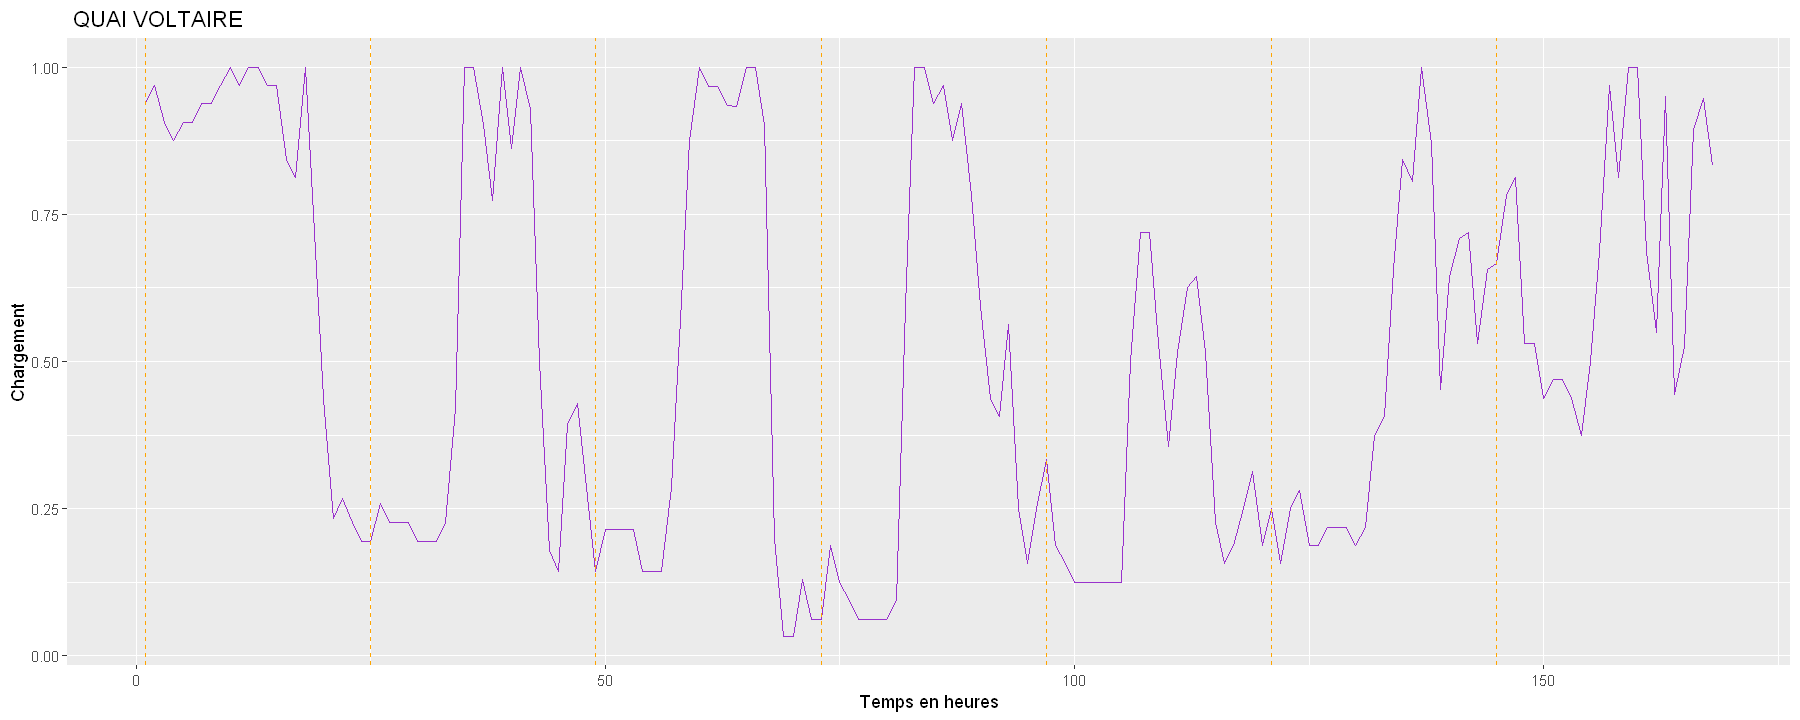

In [6]:
options(repr.plot.width = 15, repr.plot.height = 6)
time_tick = 1 + 24*(0:6)
i = sample(1:1189,1)
df = melt(loading[i,])
df$time_range = 1:ncol(loading)
ggplot(df, aes(x=time_range, y=value)) + geom_line(col="darkorchid") +
    geom_vline(xintercept=time_tick, col="orange", linetype="dashed") +
    labs(title=velib$names[i],x = "Temps en heures", y = "Chargement")

Ici on trace l'évolution du chargement d'une station au hasard

In [7]:
options(repr.plot.width = 15, repr.plot.height = 10)

timeTick = 1 + 24*(0:6)

stations = sample.int(nrow(loading), 16)

df = melt(loading[stations,])

p = list()
for (i in 1:16){
    dfi = df[df$Var1 == velib$names[stations[i]],]
    p[[i]] = ggplot(dfi, aes(x=Var2, y=value)) + 
        geom_line(col="darkorchid") + 
       geom_vline(xintercept=timeTick, col="orange", linetype="dashed") +
       labs(title=velib$names[stations[i]],x = "Temps en heures", y = "Chargement")
}
do.call(grid.arrange,p)
stations

ERROR: Error in do.call(grid.arrange, p): objet 'grid.arrange' introuvable


On peut voir que certaines stations ont des cycles de chargement distinctifs, certaines se chargent la nuit et d'autres le jour, certaines ont un faible taux de chargement toute la semaine, et d'autres ont un profil de chargement distinct entre la semaine et le week-end.

In [ ]:
print('--- Taux de chargement moyen ---')
print(mean(loading))
# --- #
print('')

print('--- Taux de chargement moyen de la station la moins remplie ---')
i = which.min(rowMeans(loading)) 
print(rowMeans(loading)[i])

# --- #
print('')

print('--- Taux de chargement moyen de la station la plus remplie ---')
i = which.max(rowMeans(loading))
print(rowMeans(loading)[i])

In [ ]:
options(repr.plot.width = 18, repr.plot.height = 6)

random_indices <- 1:nrow(loading)
df <- data.frame(stations = random_indices, mean = rowMeans(loading[random_indices, ]))

ggplot(df, aes(x = stations, y = mean)) + 
  geom_line(color = 'cornflowerblue', linewidth = 1) +
  geom_hline(yintercept = mean(loading), color = 'darkorange', linewidth = 2) +
  labs(x = "Stations", y = "Average loading")


Certaines stations sont plus souvent chargées (pleines) que d'autres. Le chargement moyen est différent pour chaque station.

Warning message:
"Ignoring unknown parameters: linewidth"

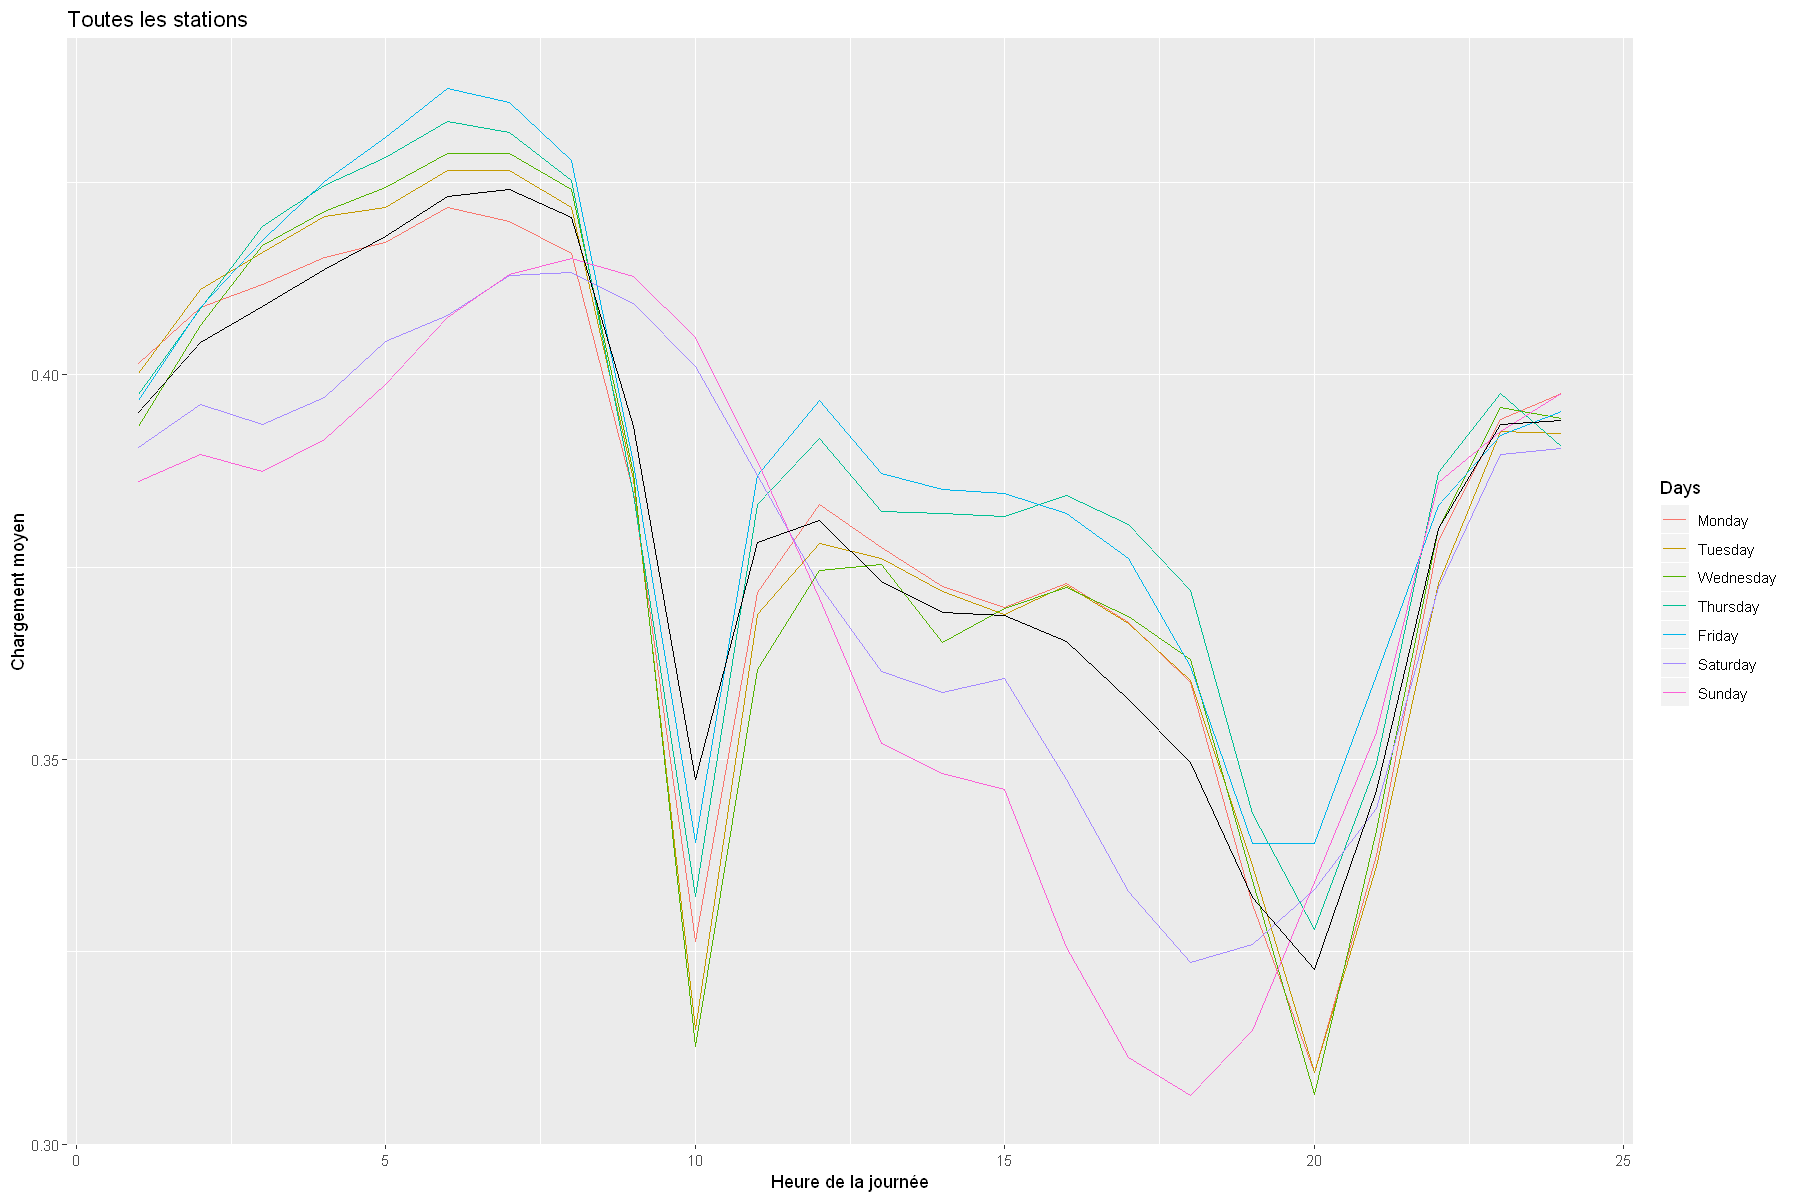

In [8]:
mean_per_hour_per_day = colMeans(loading)
mean_per_hour_per_day = matrix(mean_per_hour_per_day, nrow = 24)
mean_per_hour         = rowMeans(mean_per_hour_per_day)
# --- #

mean_per_hour_per_day            = as.data.frame(mean_per_hour_per_day)
colnames(mean_per_hour_per_day)  = list("Monday", "Tuesday", "Wednesday","Thursday", "Friday", "Saturday", "Sunday")
mean_per_hour_per_day$time_range = c(1:24)
mean_per_hour_per_day            = melt(mean_per_hour_per_day, id='time_range', variable.name='Days')

mean_per_hour            = as.data.frame(mean_per_hour)
colnames(mean_per_hour)  = list("Weekly")
mean_per_hour$time_range = c(1:24)

# --- #
options(repr.plot.width = 15, repr.plot.height = 10)

ggplot() +  
        geom_line(data=mean_per_hour_per_day, aes(x=time_range, y=value, color=Days)) + 
        geom_line(data=mean_per_hour, aes(x = time_range , y=Weekly), linewidth = 1.5) +
        labs(title = "Toutes les stations",
        x = "Heure de la journée", 
        y = "Chargement moyen")

Ici c'est le chargement moyen de toutes les stations en fonction de l'heure (chaque courbe correspond à un jour) et en noire la moyenne sur les jours de ce chargement. 

Warning message:
"Ignoring unknown parameters: linewidth"

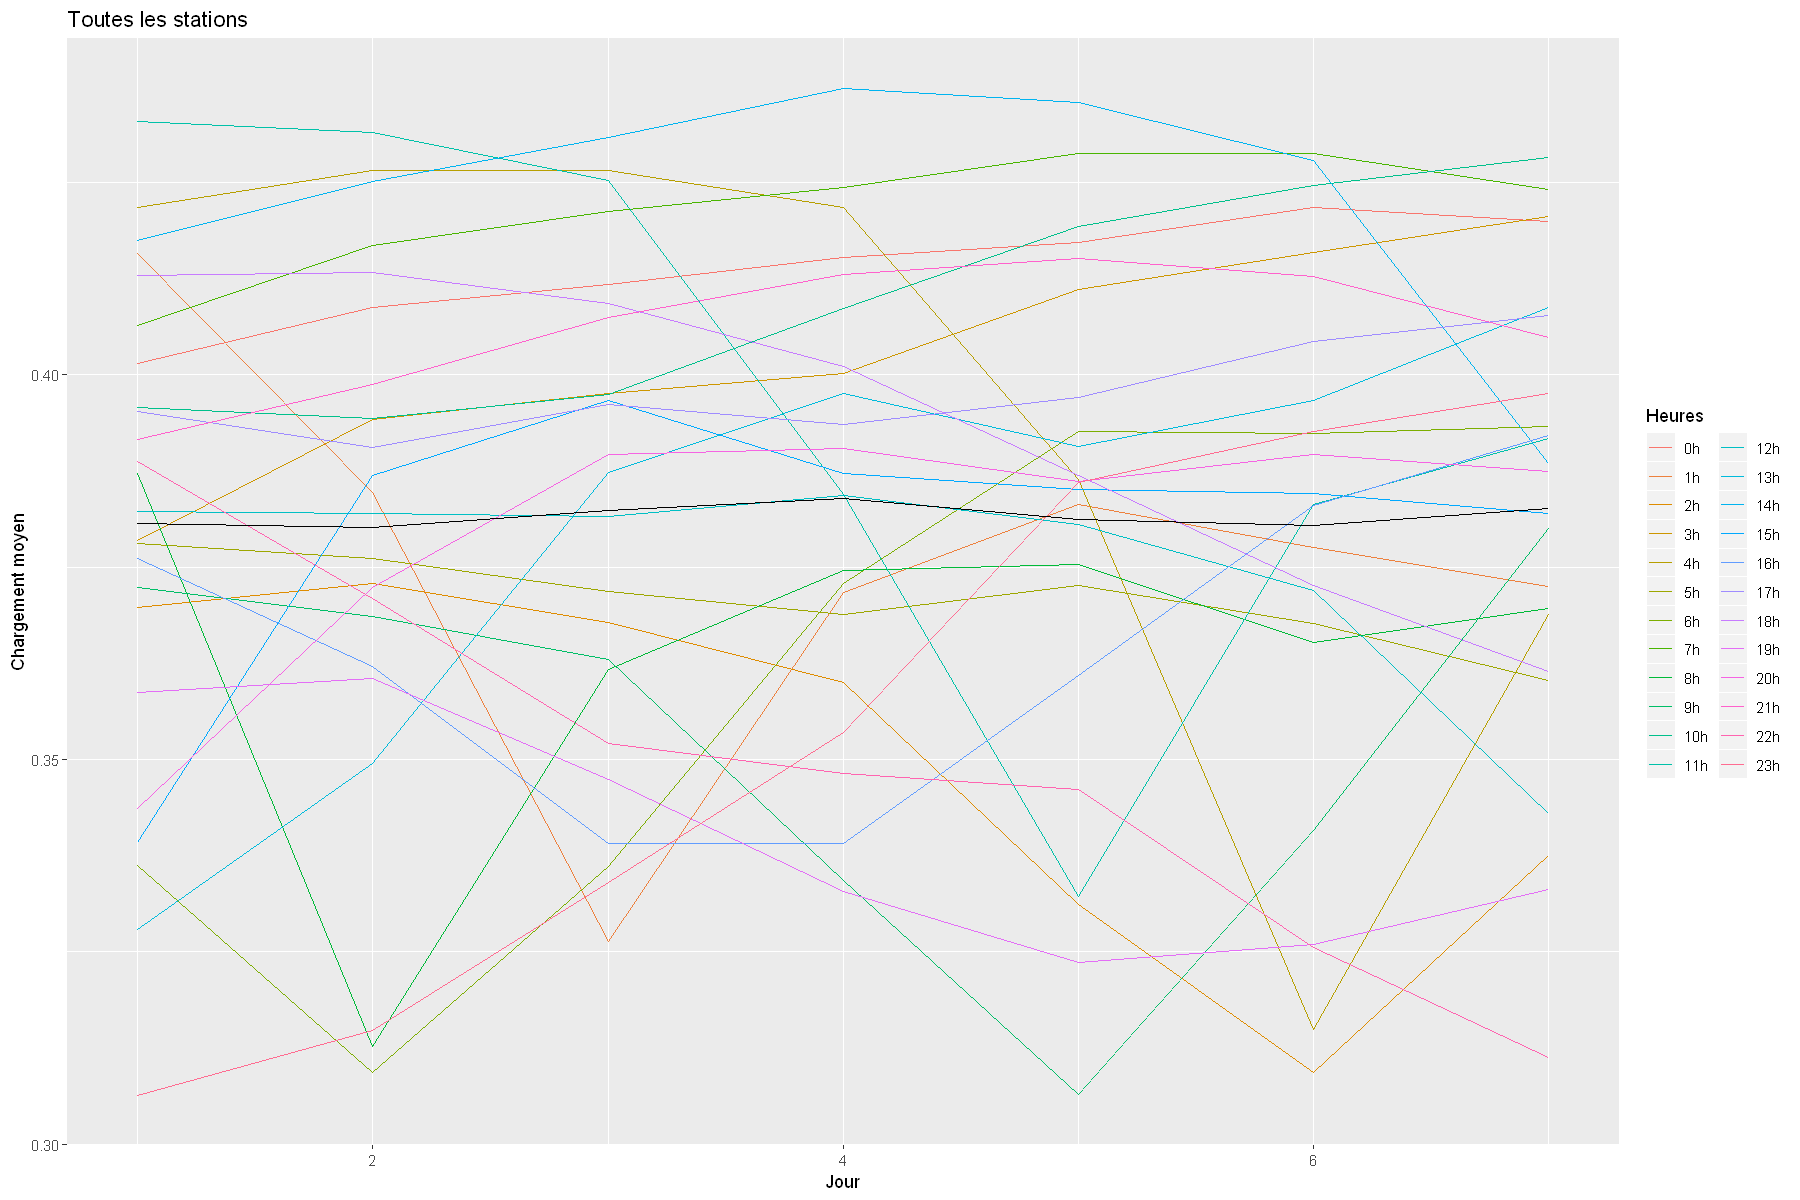

In [9]:
mean_per_hour_per_day = colMeans(loading)
mean_per_hour_per_day = matrix(mean_per_hour_per_day, nrow = 7)
mean_per_hour         = rowMeans(mean_per_hour_per_day)
# --- #

mean_per_hour_per_day            = as.data.frame(mean_per_hour_per_day)
colnames(mean_per_hour_per_day) <- list("0h", "1h", "2h","3h", "4h", "5h", "6h", "7h", "8h", "9h", "10h", "11h", "12h", "13h", "14h", "15h", "16h", "17h", "18h", "19h", "20h", "21h", "22h", "23h")
mean_per_hour_per_day$time_range = c(1:7)
mean_per_hour_per_day            = melt(mean_per_hour_per_day, id='time_range', variable.name='Heures')

mean_per_hour            = as.data.frame(mean_per_hour)
colnames(mean_per_hour)  = list("Weekly")
mean_per_hour$time_range = c(1:7)

# --- #
options(repr.plot.width = 15, repr.plot.height = 10)

ggplot() +  
        geom_line(data=mean_per_hour_per_day, aes(x=time_range, y=value, color=Heures)) + 
        geom_line(data=mean_per_hour, aes(x = time_range , y=Weekly), linewidth = 1.5) +
        labs(title="Toutes les stations",
        x = "Jour", 
        y = "Chargement moyen")

On plot le chargement moyen de toutes les stations en fonction du jour (chaque courbe correspond à une heure) et en noire la moyenne sur les heures. On peut voir que le chargement moyen est quasiment constant chaque jour même le week-end, comparé au graphe d'avant où le chargement variait légèrement. On peut donc déjà supposer une plus forte influence de l'heure sur le profil de chargement que le jour. 

In [10]:
install.packages("ggmap")
library(ggmap)
register_stadiamaps("d4f81b8a-655d-418e-841e-c5339e89ba9b", write = TRUE)
library(viridis)

also installing the dependencies 'png', 'jpeg', 'bitops'

Warning message:
"unable to access index for repository https://cran.r-project.org/bin/windows/contrib/3.6:
  impossible d'ouvrir l'URL 'https://cran.r-project.org/bin/windows/contrib/3.6/PACKAGES'"Packages which are only available in source form, and may need
  compilation of C/C++/Fortran: 'png' 'jpeg' 'bitops'


  These will not be installed


installing the source package 'ggmap'

Warning message in install.packages("ggmap"):
"installation of package 'ggmap' had non-zero exit status"

ERROR: Error in library(ggmap): there is no package called 'ggmap'


In [ ]:
options(repr.plot.width = 20, repr.plot.height = 10)
hour = c(1,5,9,13,17,21,24)

dfi = coord
p = list()
for (i in 1:length(hour)){
    h    = hour[i]
    hours = seq(h, 168, 24)
    load_per_hour = rowMeans(loading[,hours])

    df = coord
    df$loading = load_per_hour
    p[[i]] = qmplot(data=df, longitude, latitude, color=loading) + 
          geom_point(size = 2) + 
          scale_color_viridis(name = "Chargement", option = "C", direction = -1) +
          labs(title = paste('Chargement moyen à',(h-1),'h'))
}

do.call(grid.arrange,c(p, ncol=3))

On peut voir que les zones des stations chargées varient fortement au cours de la journée. Il y a un déplacement le matin entre 8 et 12h des vélos vers le centre ville et le bord de seine (qui pourraient correspondre aux zones de travail) car les stations sont en moyenne plus chargées, et elles semblent se vider entre 16h et 20h, pour se reremplir vers le sud-ouest et sud-est de Paris, qui pourraient correspondre aux zones de fêtes.

In [ ]:
lundi <- rowMeans(loading[,c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24)])
mardi <- rowMeans(loading[,c(25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48)])
mercredi <- rowMeans(loading[,c(49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72)])
jeudi <- rowMeans(loading[,c(73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96)])
vendredi <- rowMeans(loading[,c(97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120)])
samedi <- rowMeans(loading[,c(121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144)])
dimanche <- rowMeans(loading[,c(145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168)])


options(repr.plot.width = 20, repr.plot.height = 15)

days  = list("Lundi", "Mardi", "Mercredi","Jeudi", "Vendredi", "Samedi", "Dimanche")

df = coord
df$lundi = lundi
df$mardi = mardi
df$mercredi = mercredi
df$jeudi = jeudi
df$vendredi = vendredi
df$samedi = samedi
df$dimanche = dimanche
p = list()
for (i in 1:7){
    load_per_day = df[,3+i]

    dfi = coord
    dfi$loading = load_per_day
    p[[i]] = qmplot(data=dfi, longitude, latitude, color=loading) + 
          geom_point(size = 2) + 
          scale_color_viridis(name = "Chargement", option = "C", direction = -1) +
          labs(title = paste('Chargement moyen le',days[i]))
}


do.call(grid.arrange,c(p, ncol=3))

On peut voir que quand on regarde le chargement moyen par jour et non plus par heures, le chargement moyen semble beaucoup moins varier. L'influence du jour semble moindre.

## 3. Etude sur le jeu de données complet 

### 3.1. ACP

In [ ]:
### ACP
loading <- as.data.frame(loading)
loading$Hill <- as.factor(coord$bonus)
acp <- PCA(loading, scale.unit = TRUE,
           graph = FALSE, quali.sup=169, ncp = 5)
g1<-fviz_eig(acp, addlabels = TRUE, ylim = c(0, 40))
g2<-ggplot(melt(acp$ind$coord),aes(x=Var2,y=value))+
  geom_boxplot()+
  xlab("")
grid.arrange(g1,g2,ncol=2)

In [ ]:
fviz_pca_var(acp, axes = c(1,2))
fviz_pca_var(acp,axes=c(1,3))

On peut voir que la composante 1 correspond au chargement moyen des stations. Il est compliqué de trouver une interprétation à la composante 2 car nous avons trop de variables. Nous avons décidé de réduire notre nombre de variables en créant un nouveau jeu de données moyenné sur les heures.

#### 3.1.1 Méthode de clustering avec k-means

In [15]:
library(cluster)
library(RColorBrewer)
library(viridis)

ERROR: Error in library(viridis): there is no package called 'viridis'


In [12]:
options(repr.plot.width = 9, repr.plot.height = 6)
fviz_nbclust(loading[,-169], FUNcluster=kmeans, method="wss") +
    ggtitle("Score WSS")

fviz_nbclust(loading[,-169], FUNcluster=kmeans, method="silhouette") +
    ggtitle("Score Silhouette")

ERROR: Error in fviz_nbclust(loading[, -169], FUNcluster = kmeans, method = "wss"): impossible de trouver la fonction "fviz_nbclust"


In [ ]:
options(repr.plot.width = 15, repr.plot.height = 10)
for (centers in 2:5) {
  reskmeans <- kmeans(loading, centers=centers)
  sil <- silhouette(reskmeans$cluster, dist(loading))
  p <- fviz_silhouette(sil, ylim = c(-0.2, 0.6), main = paste("centers =", centers))
  print(p)
}
reskmeans = kmeans(loading,centers=4)

On choisit 4 clusters pour Kmeans sur loading car le score silhouette nous renvoie un bon score pour ce nombre et le silhouette plot n'a que très peu de valeurs négatives qui correspondraient à des stations mal classées. On aurait pu choisir 2 ou 3 clusters comme préconisé par le score silhouette mais pour avoir des interprétations plus poussées on choisit 4 clusters. 

In [ ]:
fviz_cluster(reskmeans, data=loading[,-169], ellipse.type="norm", labelsize=8, geom=c("point"))

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 6)
fviz_pca(acp, axes=c(1,2), geom = c("point"), col.ind=as.factor(reskmeans$cluster))

In [ ]:
cluster_palette <- colorFactor(c("#E41A1C","#4DAF4A","#377EB8"), domain = unique(reskmeans$cluster))  # Utiliser la palette viridis avec 10 couleurs

leaflet(velib$position) %>% 
  addTiles(urlTemplate = "https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png", 
           attribution = 'Map tiles by Carto, under CC BY 3.0. Data by OpenStreetMap, under ODbL.') %>% 
  addCircleMarkers(radius = 3,
                   color = ~cluster_palette(reskmeans$cluster),
                   stroke = FALSE, 
                   fillOpacity = 0.9) %>%
addLegend(position = "bottomright", 
            pal = cluster_palette, 
            values = ~reskmeans$cluster,
            title = "Cluster",
            opacity = 1)

In [ ]:
mean_loadings <- aggregate(loading[, -169], by = list(cluster = reskmeans$cluster), FUN = mean)
mean_loadings
mean_loadings_melted <- melt(mean_loadings, id.vars = "cluster")

ggplot(mean_loadings_melted, aes(x = variable, y = value, color = factor(cluster), group = cluster)) +
  geom_line() +
  labs(title = "Chargement moyen des stations par cluster", x = "Temps en heures", y = "Chargement") +
  scale_color_discrete(name = "Cluster")

Ce graphe représente le chargement moyen des stations en fonction du cluster. 
Le cluster 1 se charge en soirée et se vide le matin avec un chargement qui varie beaucoup. C'est des stations qui pourraient correspondre aux zones d'habitation, où les gens rentrent du travail et chargent les stations et les vident en partant au travail le matin. 
A l'inverse, le cluster 2 correspond aux stations qui se chargent en journée, quand les gens arrivent au travail et se vide quand les gens rentrent chez eux. Le week-end, le chargement du cluster 2 varie moins car moins de gens se rendent au centre. 
Le cluster 3 se charge également en journée mais les stations sont plus vides en moyenne et le chargement varie moins. 
Le cluster 4, à l'inverse du cluster 3, se charge en soirée avec des stations plus chargées en moyenne mais avec aussi un chargement qui varie moins. 

In [ ]:
tbl2 = table(coord$bonus,reskmeans$cluster)
print(tbl2)
mosaicplot(tbl2,color=c(1:4), main = "Stations en altitude en fonction du clusters")

On voit que quasiment toutes les stations en altitude appartiennent au cluster 3, qui correspond aux stations peu chargées et dont le chargement ne varie pas beaucoup. Les vélos en altitude ne sont pas pas très empruntés/rechargés.

#### 3.1.2. CAH : Agglomerative Clustering

In [ ]:
d = dist(loading[,-169], method="euclidean")

hclustaverage = hclust(d, method="average")
hclustward = hclust(d,method="ward.D")
hclustsingle = hclust(d, method="single")
hclustcomplete = hclust(d,method="complete")


options(repr.plot.width=10, repr.plot.height=10)

fviz_dend(hclustsingle, show_labels=FALSE, main='Dendrogram - Single linkage')
fviz_dend(hclustcomplete, show_labels=FALSE, main='Dendrogram - Complete linkage')
fviz_dend(hclustaverage, show_labels=FALSE, main='Dendrogram - Average linkage')
fviz_dend(hclustward, show_labels=FALSE, main='Dendrogram - Ward linkage')

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 6)
loading_dupli <- loading[!duplicated(rownames(loading)), ]
grid.arrange(
    fviz_nbclust(loading_dupli[,-169], FUNcluster=hcut, method="wss") + ggtitle("Score WSS"),
    fviz_nbclust(loading_dupli[,-169], FUNcluster=hcut, method="silhouette") + ggtitle("Score Silhouette"),
    ncol=2
)

On choisit 4 clusters car le score silhouette est bon et pour correspondre au nombre de cluster de la méthode Kmeans.

In [ ]:
reshclust_average = cutree(hclustaverage, 4)
reshclust_ward = cutree(hclustward, 4)
reshclust_complete = cutree(hclustcomplete, 4)
reshclust_single = cutree(hclustsingle, 4)

fviz_dend(hclustaverage, k=4, show_labels=FALSE, rect=TRUE, main = "Dendrogram average linkage")
fviz_dend(hclustward, k=4, show_labels=FALSE, rect=TRUE, main = "Dendrogram ward linkage")
fviz_dend(hclustsingle, k=4, show_labels=FALSE, rect=TRUE, main = "Dendrogram single linkage")
fviz_dend(hclustcomplete, k=4, show_labels=FALSE, rect=TRUE, main = "Dendrogram complete linkage")

On choisit le linkage Ward pour avoir des clusters de taille à peu près équivalente et pouvoir représenter des chargements moyens cohérents.

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 6)

fviz_pca(acp, axes=c(1,2), geom = c("point"), col.ind=as.factor(reshclust_average))

In [ ]:
cluster_palette <- colorFactor(c("#E41A1C","#4DAF4A","#377EB8"), domain = unique(reshclust_average))

leaflet(velib$position) %>% 
  addTiles(urlTemplate = "https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png", 
           attribution = 'Map tiles by Carto, under CC BY 3.0. Data by OpenStreetMap, under ODbL.') %>% 
  addCircleMarkers(radius = 3,
                   color = ~cluster_palette(reshclust_average),
                   stroke = FALSE, 
                   fillOpacity = 0.9) %>%
addLegend(position = "bottomright", 
            pal = cluster_palette, 
            values = ~reshclust_average,
            title = "Cluster",
            opacity = 1)

In [ ]:
mean_loadings_cah <- aggregate(loading[, -169], by = list(cluster = reshclust_ward), FUN = mean)
mean_loadings_cah
mean_loadings_melted_cah <- melt(mean_loadings_cah, id.vars = "cluster")

ggplot(mean_loadings_melted_cah, aes(x = variable, y = value, color = factor(cluster), group = cluster)) +
  geom_line() +
  labs(title = "Chargement moyen des stations par cluster", x = "Temps en heures", y = "Chargement") +
  scale_color_discrete(name = "Cluster")

On retrouve les mêmes conclusions qu'avec les KMeans

In [ ]:
tbl2 = table(coord$bonus,reshclust_ward)
print(tbl2)
mosaicplot(tbl2,color=c(1:4), main = "Stations en altitude en fonction du clusters")

On arrive aux mêmes conclusions qu'avec les Kmeans.

#### 3.1.3. Gaussian Mixture Models

In [ ]:
library(mclust)

In [ ]:
resBICall = mclustBIC(loading[,-169], G=1:10)
summary(resBICall)

resBICall = Mclust(loading[,-169], G=1:10)
summary(resBICall)

fviz_mclust(resBICall, what="BIC")

On peut voir que l'on peut prendre n'importe quel nombre de clusters du moment qu'on choisit un modèle EEE. On en choisit 2 car si on en prend plus ça nous donne des clusters avec qu'un seul individu.

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6)
resBIC = Mclust(loading[,-169], G=2, modelNames = "EEE")
fviz_cluster(resBIC, data=loading[,-169], ellipse.type="norm", geom="point")

# --- #

aux = data.frame(
    label = paste("Cluster", resBIC$classification, sep=""), 
    proba = apply(resBIC$z, 1, max))

ggplot(aux, aes(x=label, y=proba)) + 
    geom_boxplot(colour=1:2, fill=1:2, alpha=.4)

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 10)

grid.arrange(
    fviz_pca(acp, axes=c(1,2), geom = c("point"), col.ind=as.factor(resBIC$classification)),
    fviz_pca(acp, axes=c(1,3), geom=c("point"), col.ind=as.factor(resBIC$classification)),
    fviz_pca(acp, axes=c(2,3), geom=c("point"), col.ind=as.factor(resBIC$classification)),
    ncol=3
)

On peut voir que les clusters se différencient surtout sur la dimension 1, ie les stations non chargées et les stations chargées. Le cluster 1 semble regrouper les stations peu chargées et le 2 les stations chargées.

In [ ]:
cluster_palette <- colorFactor(c("#E41A1C","#FF33CC"), domain = unique(resBIC$classification))  # Utiliser la palette viridis avec 10 couleurs

leaflet(velib$position) %>% 
  addTiles(urlTemplate = "https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png", 
           attribution = 'Map tiles by Carto, under CC BY 3.0. Data by OpenStreetMap, under ODbL.') %>% 
  addCircleMarkers(radius = 3,
                   color = ~cluster_palette(resBIC$classification),
                   stroke = FALSE, 
                   fillOpacity = 0.9) %>%
addLegend(position = "bottomright", 
            pal = cluster_palette, 
            values = ~resBIC$classification,
            title = "Cluster",
            opacity = 1)
### pareil que pour la première carte

In [ ]:
mean_loadings_gmm <- aggregate(loading[, -169], by = list(cluster = resBIC$classification), FUN = mean)
mean_loadings_gmm
mean_loadings_melted_gmm <- melt(mean_loadings_gmm, id.vars = "cluster")

ggplot(mean_loadings_melted_gmm, aes(x = variable, y = value, color = factor(cluster), group = cluster)) +
  geom_line() +
  labs(title = "Chargement moyen des stations par cluster", x = "Temps en heures", y = "Chargement") +
  scale_color_discrete(name = "Cluster")

Ici le cluster 1 correspond aux stations moins chargées en moyenne et le cluster 2 aux stations plus chargées en moyenne.

In [ ]:
tbl2_cah = table(coord$bonus,resBIC$classification)
print(tbl2_cah)
mosaicplot(tbl2_cah,color=c(2:4), main = "Stations en altitude en fonction du clusters")

On peut voir que la plupart des stations en altitude appartiennent au cluster 1, le cluster des stations peu chargée. Cela confirme notre analyse avec les kmeans et CAH.

### 3.2. CA : comparaison méthodes de clustering

## 4. Etude sur le jeu de données par heures

### 4.1. ACP

In [ ]:
minuit_am <- rowMeans(loading[,c(1,25,49,73,97,121,145)])
une_am <- rowMeans(loading[,c(2,26,50,74,98,122,146)])
deux_am <- rowMeans(loading[,c(3,27,51,75,99,123,147)])
trois_am <- rowMeans(loading[,c(4,28,52,76,100,124,148)])
quatre_am <- rowMeans(loading[,c(5,29,53,77,101,125,149)])
cinq_am <- rowMeans(loading[,c(6,30,54,78,102,126,150)])
six_am <- rowMeans(loading[,c(7,31,55,79,103,127,151)])
sept_am <- rowMeans(loading[,c(8,32,56,80,104,128,152)])
huit_am <- rowMeans(loading[,c(9,33,57,81,105,129,153)])
neuf_am <- rowMeans(loading[,c(10,34,58,82,106,130,154)])
dix_am <- rowMeans(loading[,c(11,35,59,83,107,131,155)])
onze_am <- rowMeans(loading[,c(12,36,60,84,108,132,156)])
minuit_pm <- rowMeans(loading[,c(13,37,61,85,109,133,157)])
une_pm <- rowMeans(loading[,c(14,38,62,86,110,134,158)])
deux_pm <- rowMeans(loading[,c(15,39,63,87,111,135,159)])
trois_pm <- rowMeans(loading[,c(16,40,64,88,112,136,160)])
quatre_pm <- rowMeans(loading[,c(17,41,65,89,113,137,161)])
cinq_pm <- rowMeans(loading[,c(18,42,66,90,114,138,162)])
six_pm <- rowMeans(loading[,c(19,43,67,91,115,139,163)])
sept_pm <- rowMeans(loading[,c(20,44,68,92,116,140,164)])
huit_pm <- rowMeans(loading[,c(21,45,69,93,117,141,165)])
neuf_pm <- rowMeans(loading[,c(22,46,70,94,118,142,166)])
dix_pm <- rowMeans(loading[,c(23,47,71,95,119,143,167)])
onze_pm <- rowMeans(loading[,c(24,48,72,96,120,144,168)])
df1 <- data.frame(Minuit = minuit_am, "une h" = une_am, "2h" = deux_am, "3h" = trois_am, "4h" = quatre_am, "5h" = cinq_am, "6h" = six_am, "7h" = sept_am, "8h" = huit_am, "9h" = neuf_am
                 , "10h" = dix_am, "11h" = onze_am, "12h" = minuit_pm, "13h" = une_pm, "14h" = deux_pm, "15h" = trois_pm, "16h" = quatre_pm, "17h" = cinq_pm, "18h" = six_pm, 
                 "19h" = sept_pm, "20h" = huit_pm, "21h" = neuf_pm, "22h" = dix_pm, "23h" = onze_pm)

colnames(df1) <- list("0h", "1h", "2h","3h", "4h", "5h", "6h", "7h", "8h", "9h", "10h", "11h", "12h", "13h", "14h", "15h", "16h", "17h", "18h", "19h", "20h", "21h", "22h", "23h")
df1$Station <- velib$names
df1$Hill <- as.factor(coord$bonus)
df1$Station <- as.factor(df1$Station)
head(df1)

In [ ]:
# ACP1
acp1 <- PCA(df1, scale.unit = TRUE,
           graph = FALSE, quali.sup = c(25,26), ncp = 3)
g1<-fviz_eig(acp1, addlabels = TRUE, ylim = c(0, 60))
g2<-ggplot(melt(acp1$ind$coord),aes(x=Var2,y=value))+
  geom_boxplot()+
  xlab("")
grid.arrange(g1,g2,ncol=2)

In [ ]:
fviz_pca_var(acp1)
fviz_pca_var(acp1,axes=c(1,3))
fviz_pca_var(acp1,axes=c(2,3))

Ici, dans ce nouveau dataset, on peut voir que la composante 1 représente le chargement des stations, et que la composante 2 correspond aux heures de nuit et de jour. La composante 3 semble représenter les heures ou le chargement varie le plus, mais les variables ne sont pas très bien projetées donc cela reste à nuancer. On crée aussi un dataset en moyennant sur les jours

#### 4.1.1. Méthode de clustering avec k-means


In [ ]:
options(repr.plot.width = 9, repr.plot.height = 6)
fviz_nbclust(df1[,-c(25,26)], FUNcluster=kmeans, method="wss") +
    ggtitle("Within sum of square (WSS) according to the number of clusters")

fviz_nbclust(df1[,-c(25,26)], FUNcluster=kmeans, method="silhouette") +
    ggtitle("Silhouette score according to the number of clusters")

In [ ]:
reskmeans1 = kmeans(df1[,-c(25,26)], centers=4) 

fviz_cluster(reskmeans1, data=df1[,-c(25,26)], ellipse.type="norm", labelsize=8, geom=c("point"))

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 6)

fviz_pca(acp1, axes=c(1,2), geom = c("point"), col.ind=as.factor(reskmeans1$cluster))

On peut voir que le cluster de gauche est projeté négativement selon la dimension 1. Il correspond donc à des stations peu chargées en moyenne et il n'a pas de distinction selon la composante 2, il ne fait pas de distinction entre les stations de "nuit" et les stations de "jour". 
Le cluster de droite fait pareil sauf qu'il correspond aux stations chargées en moyenne car projeté positivement selon la dimension 1. 
Le cluster du haut lui regroupe les stations plus chargées le jour et vides la nuit, à l'inverse du cluster du bas.

In [ ]:
cluster_palette <- colorFactor(c("#E41A1C","#4DAF4A","#377EB8"), domain = unique(reskmeans1$cluster))  # Utiliser la palette viridis avec 10 couleurs

leaflet(velib$position) %>% 
  addTiles(urlTemplate = "https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png", 
           attribution = 'Map tiles by Carto, under CC BY 3.0. Data by OpenStreetMap, under ODbL.') %>% 
  addCircleMarkers(radius = 3,
                   color = ~cluster_palette(reskmeans1$cluster),
                   stroke = FALSE, 
                   fillOpacity = 0.9) %>%
addLegend(position = "bottomright", 
            pal = cluster_palette, 
            values = ~reskmeans1$cluster,
            title = "Cluster",
            opacity = 1)

In [ ]:
mean_loadings1 <- aggregate(loading[, -c(169)], by = list(cluster = reskmeans1$cluster), FUN = mean)
mean_loadings1
mean_loadings_melted1 <- melt(mean_loadings1, id.vars = "cluster")

ggplot(mean_loadings_melted1, aes(x = variable, y = value, color = factor(cluster), group = cluster)) +
  geom_line() +
  labs(title = "Chargement moyen des stations par cluster", x = "Temps en heures", y = "Chargement") +
  scale_color_discrete(name = "Cluster")

In [ ]:
tbl2_km = table(coord$bonus,reskmeans1$cluster)
print(tbl2_km)
mosaicplot(tbl2_km,color=c(1:4), main = "Stations en altitude en fonction du clusters")

On retrouve exactement les mêmes clusters/graphique que sur loading. 

#### 4.1.2. CAH : Agglomerative Clustering


In [ ]:
d1 = dist(df1[,-c(25,26)], method="euclidean")

hclustaverage1 = hclust(d1, method="average")
hclustward1 = hclust(d1,method="ward.D")
hclustsingle1 = hclust(d1, method="single")
hclustcomplete1 = hclust(d1,method="complete")


options(repr.plot.width=10, repr.plot.height=10)

fviz_dend(hclustsingle1, show_labels=FALSE, main='Dendrogram - Single linkage')
fviz_dend(hclustcomplete1, show_labels=FALSE, main='Dendrogram - Complete linkage')
fviz_dend(hclustaverage1, show_labels=FALSE, main='Dendrogram - Average linkage')
fviz_dend(hclustward1, show_labels=FALSE, main='Dendrogram - Ward linkage')

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 6)
grid.arrange(
    fviz_nbclust(df1[,-c(25,26)], FUNcluster=hcut, method="wss") + ggtitle("Score WSS"),
    fviz_nbclust(df1[,-c(25,26)], FUNcluster=hcut, method="silhouette") + ggtitle("Score Silhouette"),
    ncol=2
)

On choisit de travailler avec 4 clusters

In [ ]:
reshclust_average1 = cutree(hclustaverage1, 4)
reshclust_ward1 = cutree(hclustward1, 4)
reshclust_single1 = cutree(hclustsingle1, 4)
reshclust_average1 = cutree(hclustcomplete1, 4)

fviz_dend(hclustaverage1, k=4, show_labels=FALSE, rect=TRUE,main="Dendrogram average linkage")
fviz_dend(hclustward1, k=4, show_labels=FALSE, rect=TRUE,main="Dendrogram ward linkage")
fviz_dend(hclustsingle1, k=4, show_labels=FALSE, rect=TRUE,main="Dendrogram single linkage")
fviz_dend(hclustcomplete1, k=4, show_labels=FALSE, rect=TRUE,main="Dendrogram complete linkage")

On choisit de travailler avec le linkage Ward comme pour loading.

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 6)

fviz_pca(acp1, axes=c(1,2), geom = c("point"), col.ind=as.factor(reshclust_ward1))

On retrouve les mêmes clusters qu'avec les méthodes précedentes

In [ ]:
cluster_palette <- colorFactor(c("#E41A1C","#4DAF4A","#377EB8"), domain = unique(reshclust_ward1))

leaflet(velib$position) %>% 
  addTiles(urlTemplate = "https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png", 
           attribution = 'Map tiles by Carto, under CC BY 3.0. Data by OpenStreetMap, under ODbL.') %>% 
  addCircleMarkers(radius = 3,
                   color = ~cluster_palette(reshclust_ward1),
                   stroke = FALSE, 
                   fillOpacity = 0.9) %>%
addLegend(position = "bottomright", 
            pal = cluster_palette, 
            values = ~reshclust_average1,
            title = "Cluster",
            opacity = 1)

In [ ]:
mean_loadings_cah1 <- aggregate(loading[, -169], by = list(cluster = reshclust_ward1), FUN = mean)
mean_loadings_cah1
mean_loadings_melted_cah1 <- melt(mean_loadings_cah1, id.vars = "cluster")

ggplot(mean_loadings_melted_cah1, aes(x = variable, y = value, color = factor(cluster), group = cluster)) +
  geom_line() +
  labs(title = "Chargement moyen des stations par cluster", x = "Temps en heures", y = "Chargement") +
  scale_color_discrete(name = "Cluster")

In [ ]:
tbl2_1 = table(coord$bonus,reshclust_ward1)
print(tbl2_1)
mosaicplot(tbl2_1,color=c(1:4), main = "Stations en altitude en fonction du clusters")

Même conclusion qu'avec les méthodes précedentes. Le jeu de données df1 sur les heures semble être aussi informatif que loading.

#### 4.1.3. Gaussian Mixture Models

In [ ]:
resBICall1 = mclustBIC(df1[,-c(25,26)], G=1:10)
summary(resBICall1)

resBICall1 = Mclust(df1[,-c(25,26)], G=1:10)
summary(resBICall1)

fviz_mclust(resBICall1, what="BIC")

On prend le modèle VVE, et on choisit 4 clusters pour correspondre aux analyses précédentes et car pour le modèle VVE le BIC semble ne plus trop augmenter à partir de 4 clusters.

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6)
resBIC1 = Mclust(df1[,-c(25,26)], G=4, modelNames = "VVE")
fviz_cluster(resBIC1, data=df1[,-c(25,26)], ellipse.type="norm", geom="point")

# --- #

aux = data.frame(
    label = paste("Cluster", resBIC1$classification, sep=""), 
    proba = apply(resBIC1$z, 1, max))

ggplot(aux, aes(x=label, y=proba)) + 
    geom_boxplot(colour=1:4, fill=1:4, alpha=.4)

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 10)

fviz_pca(acp1, axes=c(1,2), geom = c("point"), col.ind=as.factor(resBIC1$classification))

In [ ]:
cluster_palette <- colorFactor(c("#E41A1C", "#FF33CC", "#377EB8", "#4DAF4A", "#FF7F00", "#FFFF33"), domain = unique(resBIC1$classification))  # Utiliser la palette viridis avec 10 couleurs

leaflet(velib$position) %>% 
  addTiles(urlTemplate = "https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png", 
           attribution = 'Map tiles by Carto, under CC BY 3.0. Data by OpenStreetMap, under ODbL.') %>% 
  addCircleMarkers(radius = 3,
                   color = ~cluster_palette(resBIC1$classification),
                   stroke = FALSE, 
                   fillOpacity = 0.9) %>%
addLegend(position = "bottomright", 
            pal = cluster_palette, 
            values = ~resBIC1$classification,
            title = "Cluster",
            opacity = 1)

In [ ]:
mean_loadings_gmm1 <- aggregate(loading[, -169], by = list(cluster = resBIC1$classification), FUN = mean)
mean_loadings_gmm1
mean_loadings_melted_gmm1 <- melt(mean_loadings_gmm1, id.vars = "cluster")

ggplot(mean_loadings_melted_gmm1, aes(x = variable, y = value, color = factor(cluster), group = cluster)) +
  geom_line() +
  labs(title = "Chargement moyen des stations par cluster", x = "Temps en heures", y = "Chargement") +
  scale_color_discrete(name = "Cluster")

In [ ]:
tbl2_gmm1 = table(coord$bonus,resBIC1$classification)
print(tbl2_gmm1)
mosaicplot(tbl2_gmm1,color=c(1:4), main = "Stations en altitude en fonction du clusters")

Le clustering GMM sur df1 donne des résultats beaucoup plus compliqués interpréter. Quand on regarde le chargement moyen par cluster, le cluster 2 et 3 semble donner la même information : ils regroupent les stations plutôt chargées en moyenne, à l'inverse du cluster 4. Le cluster 1 regroupe les stations actives en semaine, qui se chargent le matin et se vident le soir. 
Si on avait choisit que 3 clusters, c'est le cluster 1 qui aurait disparu.
On peut également voir que les stations en altitude ne sont étonnamments pas en majorité dans le cluster 4. En terme de proportion, elles sont plutôt dans le cluster 1 et 4. \
En conclusion, GMM semble être une méthode moins informative pour notre jeu de données. 

## 5. Etude sur le jeu de données par jour

### 5.1. ACP

In [ ]:
lundi <- rowMeans(loading[,c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24)])
mardi <- rowMeans(loading[,c(25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48)])
mercredi <- rowMeans(loading[,c(49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72)])
jeudi <- rowMeans(loading[,c(73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96)])
vendredi <- rowMeans(loading[,c(97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120)])
samedi <- rowMeans(loading[,c(121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144)])
dimanche <- rowMeans(loading[,c(145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168)])

df2 <- data.frame(lundi,mardi,mercredi,jeudi,vendredi,samedi,dimanche)

colnames(df2) <- list("Lundi","Mardi","Mercredi","Jeudi","Vendredi","Samedi","Dimanche")
df2$Station <- velib$names
df2$Station <- as.factor(df2$Station)
df2$Hill <- as.factor(coord$bonus)
head(df2)

In [ ]:
# ACP réduite
acp2 <- PCA(df2, scale.unit = TRUE,
           graph = FALSE, quali.sup = c(8,9), ncp = 3)
g1<-fviz_eig(acp2, addlabels = TRUE, ylim = c(0, 80))
g2<-ggplot(melt(acp2$ind$coord),aes(x=Var2,y=value))+
  geom_boxplot()+
  xlab("")
grid.arrange(g1,g2,ncol=2)

In [ ]:
fviz_pca_var(acp2)

Dans ce dataset, la composante 1 correspond toujours au chargement des stations et la composante 2 fait la distinction semaine/week-end. Cependant, les variables ne sont pas très bien projeté sur la dimension 2 donc cela reste à nuancer. Les variables étaient mieux projetées sur la dimension 2 en utilisant df1, le jeu de données sur les heures, et sur le jeu de données de base. 

#### CLUSTERING 

#### 5.1.1. Méthode de clustering avec k-means

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 6)
fviz_nbclust(df2[,-c(8,9)], FUNcluster=kmeans, method="wss") +
    ggtitle("Within sum of square (WSS) according to the number of clusters")

fviz_nbclust(df2[,-c(8,9)], FUNcluster=kmeans, method="silhouette") +
    ggtitle("Silhouette score according to the number of clusters")

In [ ]:
reskmeans2 = kmeans(df2[,-c(8,9)], centers=3) 

fviz_cluster(reskmeans2, data=df2[,-c(8,9)], ellipse.type="norm", labelsize=8, geom=c("point"))

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 6)

fviz_pca(acp2, axes=c(1,2), geom = c("point"), col.ind=as.factor(reskmeans2$cluster))

In [ ]:
cluster_palette <- colorFactor(c("#E41A1C","#4DAF4A","#377EB8"), domain = unique(reskmeans2$cluster))  # Utiliser la palette viridis avec 10 couleurs

leaflet(velib$position) %>% 
  addTiles(urlTemplate = "https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png", 
           attribution = 'Map tiles by Carto, under CC BY 3.0. Data by OpenStreetMap, under ODbL.') %>% 
  addCircleMarkers(radius = 3,
                   color = ~cluster_palette(reskmeans2$cluster),
                   stroke = FALSE, 
                   fillOpacity = 0.9) %>%
addLegend(position = "bottomright", 
            pal = cluster_palette, 
            values = ~reskmeans2$cluster,
            title = "Cluster",
            opacity = 1)

In [ ]:
mean_loadings_2 <- aggregate(loading[, -169], by = list(cluster = reskmeans2$cluster), FUN = mean)
mean_loadings_2
mean_loadings_melted_2 <- melt(mean_loadings_2, id.vars = "cluster")

ggplot(mean_loadings_melted_2, aes(x = variable, y = value, color = factor(cluster), group = cluster)) +
  geom_line() +
  labs(title = "Chargement moyen des stations par cluster", x = "Temps en heures", y = "Chargement") +
  scale_color_discrete(name = "Cluster")

In [ ]:
tbl2_km2 = table(coord$bonus,reskmeans2$cluster)
print(tbl2_km2)
mosaicplot(tbl2_km2,color=c(1:3), main = "Stations en altitude en fonction du clusters")

Sur DF2, les interprétations des clusters sont différentes. On peut voir que les clusters se différencient surtout sur leur moyenne de chargement. Le cluster 1 correspond aux stations peu chargées en moyenne (il comprend la majorité des stations en altitude). Le cluster 2 aux stations moyennement chargées et le cluster 3 aux stations chargées. On voit peu de différence entre la semaine/weekend sur le profil de chargement comparé à df1 où la moyenne de chargement des clusters étaient complétement différentes en fonction de l'heure. 
Cela confirme notre analyse descriptive : le week-end a peu d'influence sur le chargement des stations. Cela a également pu se voir par le peu d'information que porte la composante 2 dans l'acp sur df2 (8,2%)

#### 5.1.2. CAH : Agglomerative Clustering

In [ ]:
d2 = dist(df2[,-c(8,9)], method="euclidean")

hclustaverage2 = hclust(d2, method="average")
hclustward2 = hclust(d2,method="ward.D")
hclustsingle2 = hclust(d2, method="single")
hclustcomplete2 = hclust(d2,method="complete")


options(repr.plot.width=10, repr.plot.height=10)

fviz_dend(hclustsingle2, show_labels=FALSE, main='Dendrogram - Single linkage')
fviz_dend(hclustcomplete2, show_labels=FALSE, main='Dendrogram - Complete linkage')
fviz_dend(hclustaverage2, show_labels=FALSE, main='Dendrogram - Average linkage')
fviz_dend(hclustward2, show_labels=FALSE, main='Dendrogram - Ward linkage')

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 6)
grid.arrange(
    fviz_nbclust(df2[,-c(8,9)], FUNcluster=hcut, method="wss") + ggtitle("Score WSS"),
    fviz_nbclust(df2[,-c(8,9)], FUNcluster=hcut, method="silhouette") + ggtitle("Score Silhouette"),
    ncol=2
)

In [ ]:
reshclust_average2 = cutree(hclustaverage2, 3)
reshclust_ward2 = cutree(hclustward2, 3)
reshclust_single2 = cutree(hclustsingle2, 3)
reshclust_complete2 = cutree(hclustcomplete2, 3)

fviz_dend(hclustaverage2, k=3, show_labels=FALSE, rect=TRUE, main = "Average linkage Dendrogram")
fviz_dend(hclustward2, k=3, show_labels=FALSE, rect=TRUE, main = "Ward linkage Dendrogram")
fviz_dend(hclustsingle2, k=3, show_labels=FALSE, rect=TRUE, main = "Single linkage Dendrogram")
fviz_dend(hclustcomplete2, k=3, show_labels=FALSE, rect=TRUE, main = "Complete linkage Dendrogram")

On choisit le linkage Ward pour avoir des clusters de taille équivalente

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 6)

fviz_pca(acp2, axes=c(1,2), geom = c("point"), col.ind=as.factor(reshclust_ward2))

In [ ]:
cluster_palette <- colorFactor(c("#E41A1C","#4DAF4A","#377EB8"), domain = unique(reshclust_ward2))

leaflet(velib$position) %>% 
  addTiles(urlTemplate = "https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png", 
           attribution = 'Map tiles by Carto, under CC BY 3.0. Data by OpenStreetMap, under ODbL.') %>% 
  addCircleMarkers(radius = 3,
                   color = ~cluster_palette(reshclust_ward2),
                   stroke = FALSE, 
                   fillOpacity = 0.9) %>%
addLegend(position = "bottomright", 
            pal = cluster_palette, 
            values = ~reshclust_ward2,
            title = "Cluster",
            opacity = 1)

In [ ]:
mean_loadings_2cah <- aggregate(loading[, -169], by = list(cluster = reshclust_ward2), FUN = mean)
mean_loadings_2cah
mean_loadings_melted_2cah <- melt(mean_loadings_2cah, id.vars = "cluster")

ggplot(mean_loadings_melted_2cah, aes(x = variable, y = value, color = factor(cluster), group = cluster)) +
  geom_line() +
  labs(title = "Chargement moyen des stations par cluster", x = "Temps en heures", y = "Chargement") +
  scale_color_discrete(name = "Cluster")

In [ ]:
tbl2_ch2 = table(coord$bonus,reshclust_ward2)
print(tbl2_ch2)
mosaicplot(tbl2_ch2,color=c(1:3), main = "Stations en altitude en fonction du clusters")

On retrouve exactement les mêmes conclusions qu'avec les K-Means.

#### 5.1.3. Gaussian Mixture Model

In [ ]:
resBICall2 = mclustBIC(df2[,-c(8,9)], G=1:10)
summary(resBICall2)

resBICall2 = Mclust(df2[,-c(8,9)], G=1:10)
summary(resBICall2)

fviz_mclust(resBICall2, what="BIC")

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6)
resBIC2 = Mclust(df2[,-c(8,9)], G=3, modelNames = "VEE")
fviz_cluster(resBIC2, data=df2[,-c(8,9)], ellipse.type="norm", geom="point")

# --- #

aux = data.frame(
    label = paste("Cluster", resBIC2$classification, sep=""), 
    proba = apply(resBIC2$z, 1, max))

ggplot(aux, aes(x=label, y=proba)) + 
    geom_boxplot(colour=1:3, fill=1:3, alpha=.4)

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 10)

fviz_pca(acp2, axes=c(1,2), geom = c("point"), col.ind=as.factor(resBIC2$classification))

In [ ]:
cluster_palette <- colorFactor(c("#E41A1C", "#FF33CC", "#377EB8", "#4DAF4A", "#FF7F00", "#FFFF33"), domain = unique(resBIC2$classification))  # Utiliser la palette viridis avec 10 couleurs

leaflet(velib$position) %>% 
  addTiles(urlTemplate = "https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png", 
           attribution = 'Map tiles by Carto, under CC BY 3.0. Data by OpenStreetMap, under ODbL.') %>% 
  addCircleMarkers(radius = 3,
                   color = ~cluster_palette(resBIC2$classification),
                   stroke = FALSE, 
                   fillOpacity = 0.9) %>%
addLegend(position = "bottomright", 
            pal = cluster_palette, 
            values = ~resBIC2$classification,
            title = "Cluster",
            opacity = 1)

In [ ]:
mean_loadings_2gmm <- aggregate(loading[, -169], by = list(cluster = resBIC2$classification), FUN = mean)
mean_loadings_2gmm
mean_loadings_melted_2gmm <- melt(mean_loadings_2gmm, id.vars = "cluster")

ggplot(mean_loadings_melted_2gmm, aes(x = variable, y = value, color = factor(cluster), group = cluster)) +
  geom_line() +
  labs(title = "Chargement moyen des stations par cluster", x = "Temps en heures", y = "Chargement") +
  scale_color_discrete(name = "Cluster")

In [ ]:
tbl2_ch2 = table(coord$bonus,resBIC2$classification)
print(tbl2_ch2)
mosaicplot(tbl2_ch2,color=c(1:3), main = "Stations en altitude en fonction du clusters")

Même conclusion que CAH et K-Means sur le chargement moyen des différents clusters sauf que les stations en altitude ne sont pas toutes dans le cluster 3 qui correspond aux stations faiblement chargées en moyenne.

### 5.2. CA : comparaison entre CAH ET KMEANS 

In [ ]:
table_contingence <- table(reskmeans2$cluster,reshclust_ward2)
table_contingence

In [ ]:
res.ca = CA(table_contingence, graph=FALSE)
fviz_ca_biplot(res.ca, repel=TRUE)

In [ ]:
table_contingence2 <- table(reskmeans2$cluster,resBIC2$classification)
table_contingence2

In [ ]:
res.ca2 = CA(table_contingence2, graph=FALSE)
fviz_ca_biplot(res.ca2, repel=TRUE)

On peut voir que les clusters entre K-Means et CAH sur DF2 sont quasiment les mêmes alors que entre GMM et K-Means les clusters ne sont pas exactement pareil, d'où la différence par exemple entre la distribution des stations en altitude dans les clusters.

## 6. MCA sur data_heures

In [ ]:
minuit_am <- rowMeans(loading[,c(1,25,49,73,97,121,145)])
une_am <- rowMeans(loading[,c(2,26,50,74,98,122,146)])
deux_am <- rowMeans(loading[,c(3,27,51,75,99,123,147)])
trois_am <- rowMeans(loading[,c(4,28,52,76,100,124,148)])
quatre_am <- rowMeans(loading[,c(5,29,53,77,101,125,149)])
cinq_am <- rowMeans(loading[,c(6,30,54,78,102,126,150)])
six_am <- rowMeans(loading[,c(7,31,55,79,103,127,151)])
sept_am <- rowMeans(loading[,c(8,32,56,80,104,128,152)])
huit_am <- rowMeans(loading[,c(9,33,57,81,105,129,153)])
neuf_am <- rowMeans(loading[,c(10,34,58,82,106,130,154)])
dix_am <- rowMeans(loading[,c(11,35,59,83,107,131,155)])
onze_am <- rowMeans(loading[,c(12,36,60,84,108,132,156)])
minuit_pm <- rowMeans(loading[,c(13,37,61,85,109,133,157)])
une_pm <- rowMeans(loading[,c(14,38,62,86,110,134,158)])
deux_pm <- rowMeans(loading[,c(15,39,63,87,111,135,159)])
trois_pm <- rowMeans(loading[,c(16,40,64,88,112,136,160)])
quatre_pm <- rowMeans(loading[,c(17,41,65,89,113,137,161)])
cinq_pm <- rowMeans(loading[,c(18,42,66,90,114,138,162)])
six_pm <- rowMeans(loading[,c(19,43,67,91,115,139,163)])
sept_pm <- rowMeans(loading[,c(20,44,68,92,116,140,164)])
huit_pm <- rowMeans(loading[,c(21,45,69,93,117,141,165)])
neuf_pm <- rowMeans(loading[,c(22,46,70,94,118,142,166)])
dix_pm <- rowMeans(loading[,c(23,47,71,95,119,143,167)])
onze_pm <- rowMeans(loading[,c(24,48,72,96,120,144,168)])
df1 <- data.frame(Minuit = minuit_am, "une h" = une_am, "2h" = deux_am, "3h" = trois_am, "4h" = quatre_am, "5h" = cinq_am, "6h" = six_am, "7h" = sept_am, "8h" = huit_am, "9h" = neuf_am
                 , "10h" = dix_am, "11h" = onze_am, "12h" = minuit_pm, "13h" = une_pm, "14h" = deux_pm, "15h" = trois_pm, "16h" = quatre_pm, "17h" = cinq_pm, "18h" = six_pm, 
                "19h" = sept_pm, "20h" = huit_pm, "21h" = neuf_pm, "22h" = dix_pm, "23h" = onze_pm)

colnames(df1) <- list("0h", "1h", "2h","3h", "4h", "5h", "6h", "7h", "8h", "9h", "10h", "11h", "12h", "13h", "14h", "15h", "16h", "17h", "18h", "19h", "20h", "21h", "22h", "23h")
remplacer_valeurs <- function(valeur) {
  ifelse(valeur >= 0 & valeur <= 0.2, "-", 
         ifelse(valeur > 0.2 & valeur <= 0.6, "=", "+"))
}
df1 <- as.data.frame(sapply(df1, remplacer_valeurs))
df1$Station <- velib$names
df1$Hill <- as.factor(coord$bonus)
df1$Station <- as.factor(df1$Station)
df1[] <- lapply(df1, as.factor)
head(df1)

Pour appliquer la MCA, on seuil notre chargement afin de le transformer en variable qualitative.

In [ ]:
res.mca1 = MCA(df1[c(1:24,26)],graph=FALSE)
head(res.mca1$eig)

fviz_screeplot(res.mca1, addlabels=TRUE)
fviz_screeplot(res.mca1, addlabels=TRUE, ncp=7)
fviz_mca_biplot(res.mca1)
fviz_mca_biplot(res.mca1, axes=c(1,3))

In [ ]:
fviz_contrib(res.mca1, choice="var", axes=1, top=20)

fviz_contrib(res.mca1, choice="var", axes=2, top=20)

fviz_contrib(res.mca1, choice="var", axes=3, top=20)

On peut voir que pour la composante 1, c'est les heures de nuit chargées qui contribuent fortement. Pour la composante 2, plutôt les heures de journée et de nuit faiblement chargées et pour la composante 3 les heures de nuits moyennement chargées.

In [ ]:
fviz_mca_var(res.mca1, col.var = "contrib",
             gradient.cols = c("blue", "yellow", "red"), axes=c(1,2),
             repel = TRUE)
fviz_mca_var(res.mca1, col.var = "contrib",
             gradient.cols = c("blue", "yellow", "red"), axes=c(1,3),
             repel = TRUE)

On peut voir que les stations en altitude sont négativement corrélées à la dimension 1 et se retrouvent avec les stations peu chargées en moyenne.

In [ ]:
resBICall = mclustBIC(res.mca1$ind$coord, G=1:10)
summary(resBICall)

# --- #

resBICall = Mclust(res.mca1$ind$coord, G=1:10)
summary(resBICall)


fviz_mclust(resBICall, what="BIC")

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6)
resBICmca = Mclust(res.mca1$ind$coord, G=4, modelNames = "EEV")
fviz_cluster(resBICmca, data=res.mca1$ind$coord, ellipse.type="norm", geom="point")

aux = data.frame(
    label = paste("Cluster", resBICmca$classification, sep=""), 
    proba = apply(resBICmca$z, 1, max))

ggplot(aux, aes(x=label, y=proba)) + 
    geom_boxplot(colour=1:4, fill=1:4, alpha=.4)

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 6)
fviz_mca_biplot(res.mca1, col.ind = as.factor(resBICmca$classification), geom = c("point"))
fviz_mca_var(res.mca1, repel = TRUE)
fviz_mca_biplot(res.mca1, col.ind = as.factor(resBICmca$classification), geom = c("point"), axes = c(2,3))
fviz_mca_var(res.mca1, repel = TRUE, axes = c(2,3))

In [ ]:
mean_loadings_mca <- aggregate(loading[, -169], by = list(cluster = resBICmca$classification), FUN = mean)

mean_loadings_melted_mca <- melt(mean_loadings_mca, id.vars = "cluster")

ggplot(mean_loadings_melted_mca, aes(x = variable, y = value, color = factor(cluster), group = cluster)) +
  geom_line() +
  labs(title = "Chargement moyen des stations par cluster", x = "Temps en heures", y = "Chargement") +
  scale_color_discrete(name = "Cluster")

In [ ]:
cluster_palette <- colorFactor(c("#E41A1C","#4DAF4A","#377EB8","#FF7F00"), domain = unique(resBICmca$classification))  # Utiliser la palette viridis avec 10 couleurs

leaflet(velib$position) %>% 
  addTiles(urlTemplate = "https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png", 
           attribution = 'Map tiles by Carto, under CC BY 3.0. Data by OpenStreetMap, under ODbL.') %>% 
  addCircleMarkers(radius = 3,
                   color = ~cluster_palette(resBICmca$classification),
                   stroke = FALSE, 
                   fillOpacity = 0.9) %>%
addLegend(position = "bottomright", 
            pal = cluster_palette, 
            values = ~resBICmca$classification,
            title = "Cluster",
            opacity = 1)

Avec GMM sur la MCA, on retrouve les mêmes conclusions qu'avec les k-means/cah sur loading et df1

In [ ]:
def_pred_station <- function(coord1, coord2) {
    min <- 1000
    r <- 1
    for (i in 1:nrow(coord)) {
        resultat <- sqrt((coord1 - coord[i,1])^2 + (coord2 - coord[i,2])^2)
        if (resultat < min) {
            min <- resultat
            r <- i
        }
    }
    result <- reskmeans$cluster[i]
    return(result)
}

In [ ]:
def_pred_station(2.35,48.45)

On crée une fonction qui prédit à quel cluster pourrait appartenir une nouvelle station implementée à une latitude x et une longitude y. On regarde à quel station elle est la plus proche géographiquement et on lui attribue le même cluster que cette station. \
Dans notre exemple, la station avec une latitude 2.35 et une longitude 48.45 appartiendrait au cluster 2, ie au cluster des stations qui se chargent en journée qui correspond aux stations proche des lieux de travails. 

## 7. Conclusion

Dans ce projet, on a remarqué que le profil de chargement d'une station dépend de sa location. Le chargement varie surtout en fonction des heures de la journée mais un peu moins entre le week-end et la semaine. \
Dans nos méthodes de clustering K-Means et CAH, on a repéré 4 types de stations : les stations qui se chargent en journée et qui se vident en soirée, qui correspondent aux zones de travail. Ces stations sont également en moyenne moins chargées et peu moins active le week-end. \
Les stations qui elles se chargent en soirée et se vide le matin : elles correspondent aux zones d'habitation. Leur chargement reste élevé le week-end et varie moins car les gens n'ont pas besoin de se rendre à leur lieu de travail. \
Enfin, 2 autres types de clusters : les stations avec un chargement élevé en moyenne mais dont le chargement ne varie pas beaucoup et les stations avec un chargement faible en moyenne et dont le chargement ne varie pas beaucoup. On a vu que les stations en altitude sont en majorité dans ce dernier cluster. Ces deux clusters correspondent aux stations moins empruntées. \
Le GMM lui nous rend en moyenne 2/3 clusters : il différencie les stations par leur chargement moyen et non pas par la variabilité de leur chargement.